In [1]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt

import cv2
from PIL import Image

In [2]:
class VideoRecord(object):
    def __init__(self, video_path, label):
        self.path = video_path
        self.video = cv2.VideoCapture(self.path)
        self.num_frames = self._get_num_frames()
        self.label = label

    def _get_num_frames(self):
        count = 0
        success, frame = self.video.read()
        while(success):
            success, frame = self.video.read()
            count += 1
        self.video.set(2, 0)
        return count

    def get_frames(self, indices):
        """
        Argument:
            indices : Sorted list of frames indices
        Returns:
            images : Dictionary in format {frame_id: PIL Image}
        """
        images = dict()
        self.video.set(cv2.CAP_PROP_POS_FRAMES, min(indices))
        for count in range(min(indices), max(indices)+1):
            success, frame = self.video.read()
            if success is False:
                print('\nCould not load frame {} from video {}\n'.format(count, self.path))
                return None

            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            if count in indices:
                images[count] = Image.fromarray(frame)

        return images


In [4]:
def parse_list(list_file):
        video_list = []
        with open(list_file) as f:
            reader = csv.DictReader(f)
            for i, row in enumerate(reader):
                if i%10 == 0:
                    vid = row['id']
                    actions = row['actions']
                    if actions == '':
                        actions = []
                    else:
                        actions = [a.split(' ') for a in actions.split(';')]
                        actions = [{'class': x, 'start': float(
                            y), 'end': float(z)} for x, y, z in actions]
                    video_list.append([actions, vid])
                
        return video_list

In [5]:
train_file = '/media/v-pakova/New Volume/Datasets/Charades/Annotations/Charades_v1_train.csv'
root_path = '/media/v-pakova/New Volume/Datasets/Charades/Charades_v1_480'
num_classes = 157
FPS = 24

video_list = parse_list(train_file)

In [7]:
targets = np.zeros((len(video_list), num_classes))
actual_targets = np.zeros((len(video_list), num_classes))
for i, (label, video_path) in enumerate(video_list):
    if i%100 == 0:
        print(i)
    record = VideoRecord(os.path.join(root_path, video_path+'.mp4'), label)
    for l in label:
        targets[i, int(l['class'][1:])] = 1
        
        frame_start = int(l['start'] * FPS)
        if frame_start < record.num_frames:
            actual_targets[i, int(l['class'][1:])] = 1

np.stack(actual_targets)

per_label_sum = np.sum(targets, axis=0)
actual_per_label_sum = np.sum(actual_targets, axis=0)


weights = max(per_label_sum) / per_label_sum

0
100
200
300
400
500
600
700


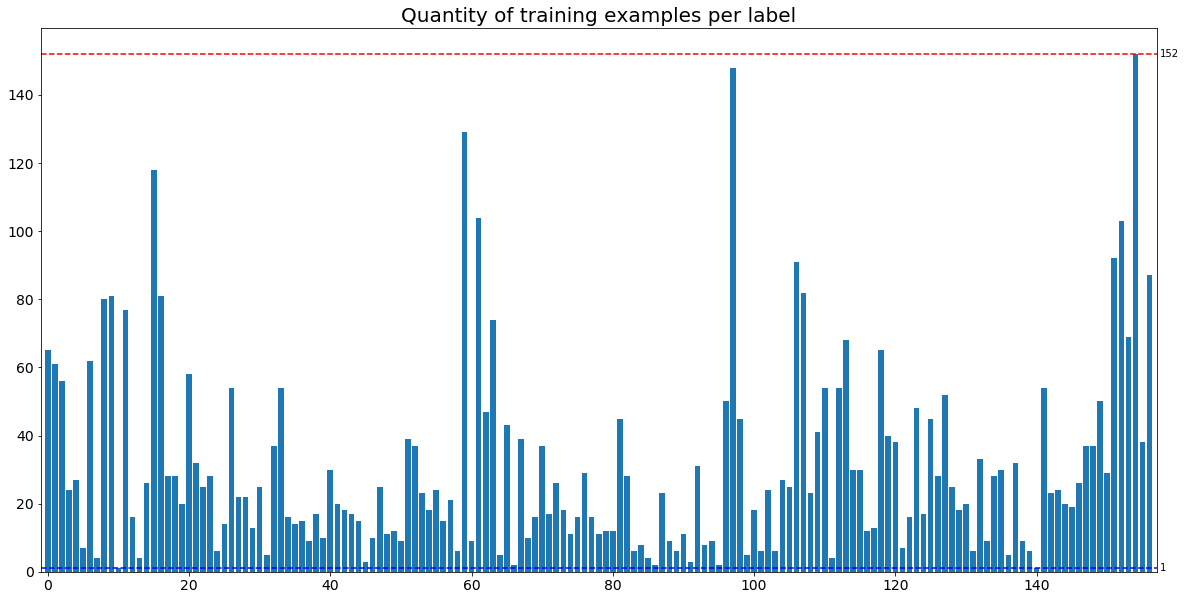

In [8]:
x = np.arange(num_classes)

plt.figure(figsize=(20,10))
plt.bar(x, per_label_sum)
plt.xlim(-1, num_classes)

plt.axhline(max(per_label_sum), linestyle='--', color='r')
plt.axhline(min(per_label_sum), linestyle='--', color='b')
    
l, r = plt.xlim()
plt.text(r+.5, max(per_label_sum), int(max(per_label_sum)), va='center', ha="left")
plt.text(r+.5, min(per_label_sum), int(min(per_label_sum)), va='center', ha="left")

plt.title('Quantity of training examples per label', fontsize=20)
plt.tick_params(labelsize=14)

plt.show()

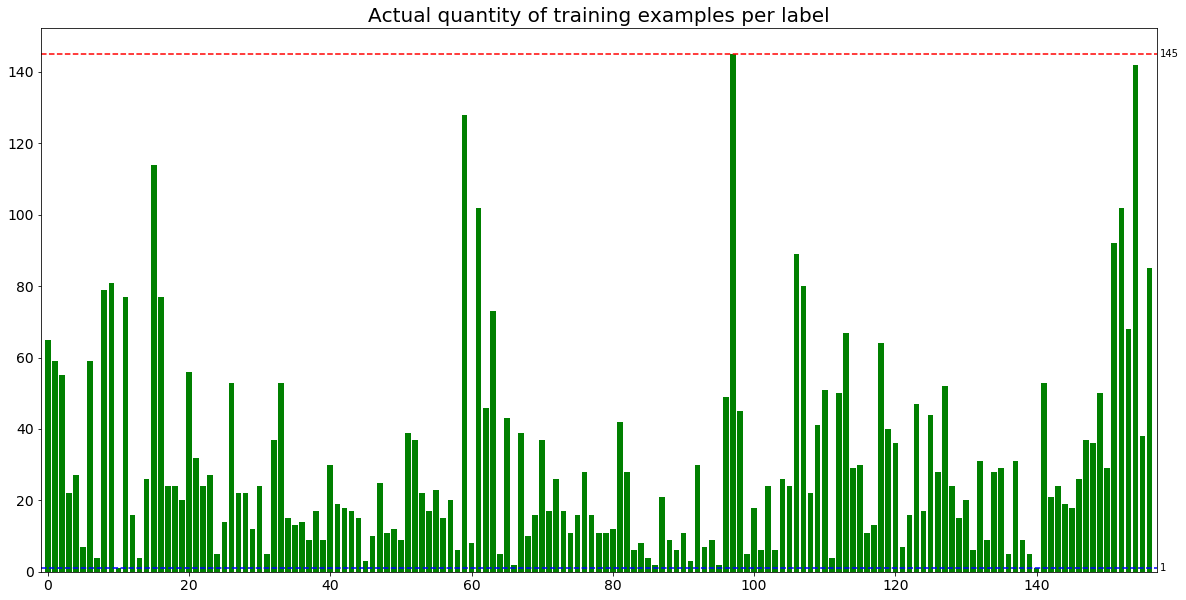

In [9]:
x = np.arange(num_classes)

plt.figure(figsize=(20,10))
plt.bar(x, actual_per_label_sum, color='g')
plt.xlim(-1, num_classes)

plt.axhline(max(actual_per_label_sum), linestyle='--', color='r')
plt.axhline(min(actual_per_label_sum), linestyle='--', color='b')
    
l, r = plt.xlim()
plt.text(r+.5, max(actual_per_label_sum), int(max(actual_per_label_sum)), va='center', ha="left")
plt.text(r+.5, min(actual_per_label_sum), int(min(actual_per_label_sum)), va='center', ha="left")

plt.title('Actual quantity of training examples per label', fontsize=20)
plt.tick_params(labelsize=14)

plt.show()

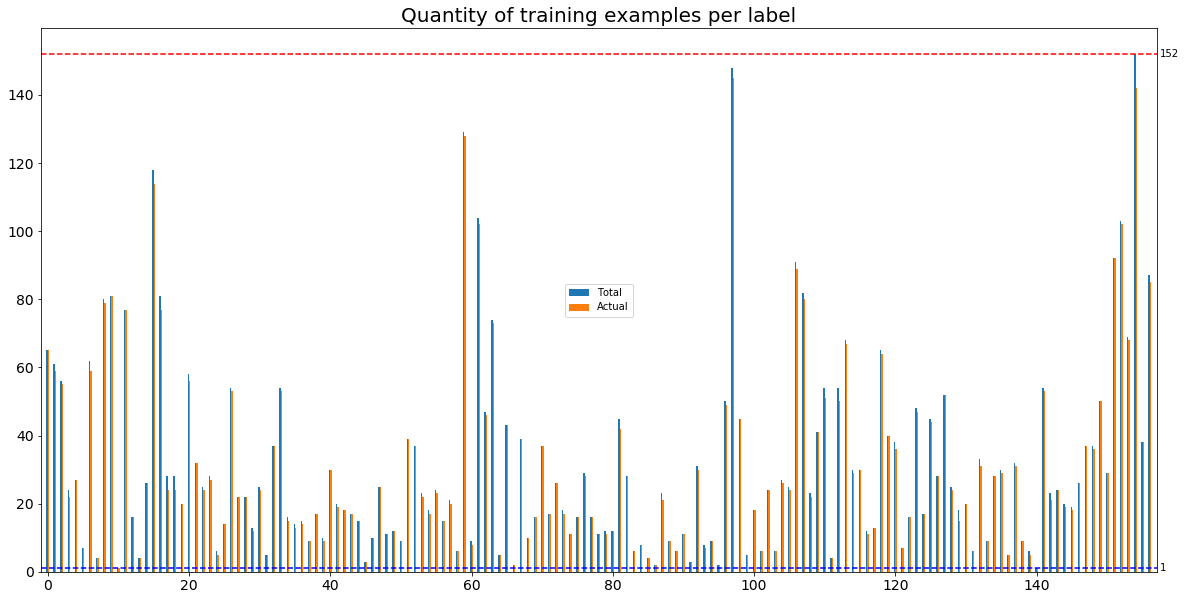

In [10]:
x = np.arange(num_classes)

plt.figure(figsize=(20,10))
# plt.bar(x, per_label_sum)
plt.xlim(-1, num_classes)

width = 0.2  # the width of the bars

rects1 = plt.bar(x - width/2, per_label_sum, width, label='Total')
rects2 = plt.bar(x + width/2, actual_per_label_sum, width, label='Actual')

plt.legend()

plt.axhline(max(per_label_sum), linestyle='--', color='r')
plt.axhline(min(per_label_sum), linestyle='--', color='b')
    
l, r = plt.xlim()
plt.text(r+.5, max(per_label_sum), int(max(per_label_sum)), va='center', ha="left")
plt.text(r+.5, min(per_label_sum), int(min(per_label_sum)), va='center', ha="left")

plt.title('Quantity of training examples per label', fontsize=20)
plt.tick_params(labelsize=14)

plt.show()

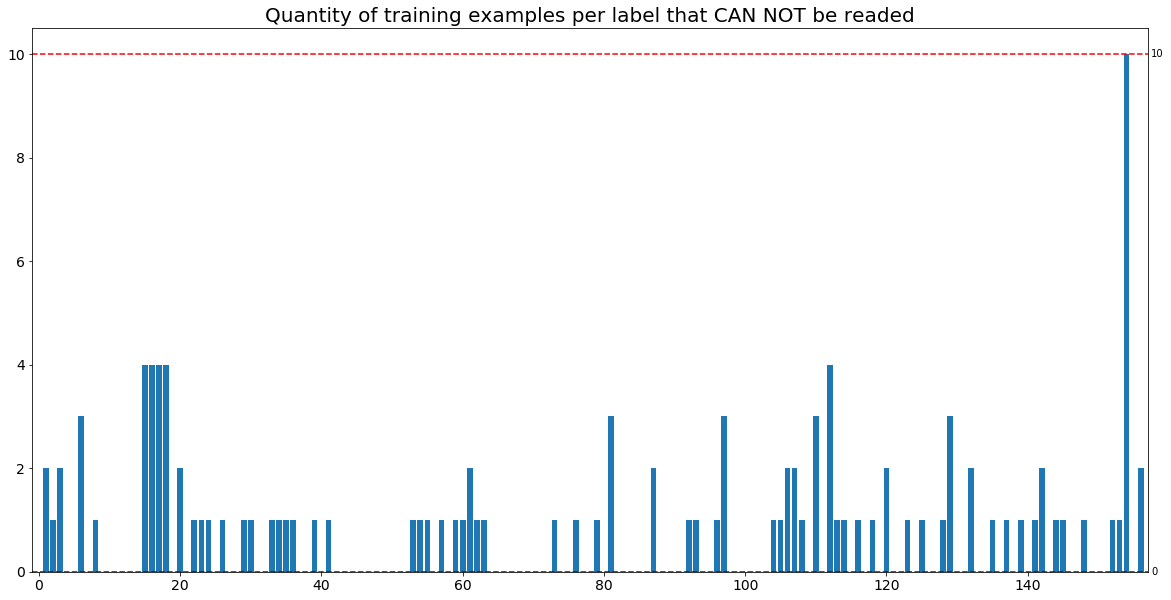

In [11]:
x = np.arange(num_classes)

diff = per_label_sum - actual_per_label_sum

plt.figure(figsize=(20,10))
plt.bar(x, diff)
plt.xlim(-1, num_classes)

plt.axhline(max(diff), linestyle='--', color='r')
plt.axhline(min(diff), linestyle='--', color='b')
    
l, r = plt.xlim()
plt.text(r+.5, max(diff), int(max(diff)), va='center', ha="left")
plt.text(r+.5, min(diff), int(min(diff)), va='center', ha="left")

plt.title('Quantity of training examples per label that CAN NOT be readed', fontsize=20)
plt.tick_params(labelsize=14)

plt.show()

In [12]:
print('Annotated labels: {} | Readable labels: {} ({:.2f}%) | Diff: {}'.format(
    sum(per_label_sum), sum(actual_per_label_sum), sum(actual_per_label_sum)*100/sum(per_label_sum), sum(diff), ))

Annotated labels: 4867.0 | Readable labels: 4753.0 (97.66%) | Diff: 114.0


In [13]:
len_labels = []
for i, (label, video_path) in enumerate(video_list):
    len_labels.append(len(label))
    
len_labels = sorted(len_labels)

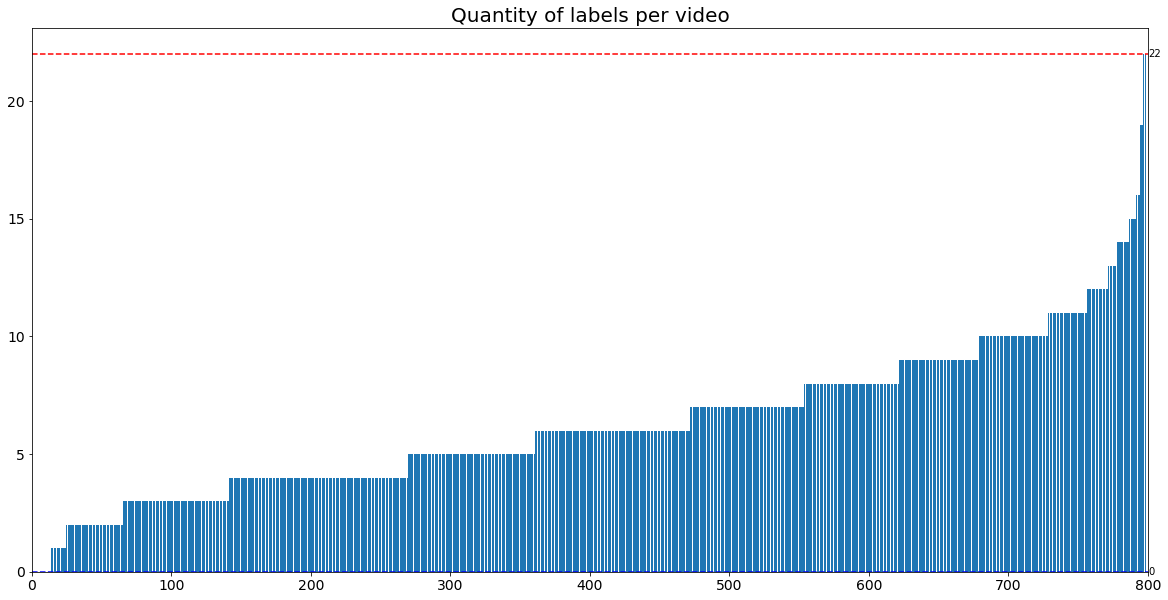

In [14]:
x = np.arange(len(video_list))

plt.figure(figsize=(20,10))
plt.bar(x, len_labels)
plt.xlim(0, len(video_list)+1)

plt.axhline(max(len_labels), linestyle='--', color='r')
plt.axhline(min(len_labels), linestyle='--', color='b')
    
l, r = plt.xlim()
plt.text(r+.5, max(len_labels), int(max(len_labels)), va='center', ha="left")
plt.text(r+.5, min(len_labels), int(min(len_labels)), va='center', ha="left")

plt.title('Quantity of labels per video', fontsize=20)
plt.tick_params(labelsize=14)

plt.show()

In [15]:
classes_frames = np.zeros((num_classes))
total_frames = 0
    
with open(train_file) as f:
    reader = csv.DictReader(f)
    for row in reader:
        actions = row['actions']
        
        total_frames += int(float(row['length']) * FPS)
        
        if actions:
            actions = [a.split(' ') for a in actions.split(';')]
            actions = [{'class': x, 'start': float(
                y), 'end': float(z)} for x, y, z in actions]
            for l in actions:
                frame_start = int(l['start'] * FPS)
                frame_end = int(l['end'] * FPS)
                classes_frames[int(l['class'][1:])] += frame_end - frame_start

In [16]:
np.mean(per_video_ratio)

NameError: name 'per_video_ratio' is not defined

In [ ]:
total_frames

In [17]:
classes_frames

array([206202., 165453., 112929.,  58321., 107048.,  31164., 104726.,
        12520., 131899., 158429.,  22958., 408107.,  78863.,  15272.,
       132526., 495039., 293604.,  38098.,  58210., 110994., 259468.,
        68817.,  51767.,  54004.,  13287.,  26509., 276472.,  59263.,
        46621.,  29351.,  52355.,   8883., 205930., 222532.,  55683.,
        51810.,  24262.,  43303.,  80996.,  19846., 121874.,  37048.,
        40759.,  37422.,  37832.,   5201.,  15828., 116689.,  17648.,
        15649.,  16093., 163375., 164621.,  78320.,  38839.,  56642.,
        36495.,  47705.,  14036., 666520.,  19454., 456298., 121693.,
       159270.,  10353., 164599.,  13377., 177945.,  26625.,  30717.,
       187730.,  44904., 149884.,  41325.,  17046.,  45131., 153134.,
        32044.,  63160.,  29111.,  22545., 103849.,  88661.,  14554.,
        56582.,   9346.,  13556.,  67947.,  74961.,  11976.,  20678.,
        13968.,  96486.,  42266.,  32326.,  13993., 163448., 227659.,
       160732.,  175

In [18]:
pos_weigth = [(total_frames-p)/p for p in classes_frames]

In [19]:
pos_weigth

[26.759565862600752,
 33.59639897735308,
 49.68740536089047,
 97.14780267828056,
 52.47206860473806,
 182.67597227570275,
 53.65765903405076,
 456.1947284345048,
 42.397432884252346,
 35.13024130683145,
 248.32825158985975,
 13.025924573702484,
 71.5825545566362,
 373.8086694604505,
 42.19211324570273,
 10.562882924375655,
 18.495912862222585,
 149.2461546537876,
 97.33495962892974,
 50.571057895021355,
 21.060824456194982,
 82.17825537294564,
 109.57387911217572,
 104.99359306718021,
 429.8028900428991,
 214.92960881210155,
 19.704006192308807,
 95.58771915022864,
 121.77896227022157,
 194.02156655650575,
 108.3320217744246,
 643.38568051334,
 26.796231729228378,
 24.722493843582047,
 101.79758633694306,
 109.48210770121598,
 234.9277058775039,
 131.1866383391451,
 69.67111956145982,
 287.4247707346569,
 45.96717921788076,
 153.50437270567912,
 139.43715498417527,
 151.96023729357063,
 150.3025481074223,
 1099.5725821957317,
 360.64253222137984,
 48.054135351232766,
 323.347121486854,

In [20]:
weights

array([  2.33846154,   2.49180328,   2.71428571,   6.33333333,
         5.62962963,  21.71428571,   2.4516129 ,  38.        ,
         1.9       ,   1.87654321, 152.        ,   1.97402597,
         9.5       ,  38.        ,   5.84615385,   1.28813559,
         1.87654321,   5.42857143,   5.42857143,   7.6       ,
         2.62068966,   4.75      ,   6.08      ,   5.42857143,
        25.33333333,  10.85714286,   2.81481481,   6.90909091,
         6.90909091,  11.69230769,   6.08      ,  30.4       ,
         4.10810811,   2.81481481,   9.5       ,  10.85714286,
        10.13333333,  16.88888889,   8.94117647,  15.2       ,
         5.06666667,   7.6       ,   8.44444444,   8.94117647,
        10.13333333,  50.66666667,  15.2       ,   6.08      ,
        13.81818182,  12.66666667,  16.88888889,   3.8974359 ,
         4.10810811,   6.60869565,   8.44444444,   6.33333333,
        10.13333333,   7.23809524,  25.33333333,   1.17829457,
        16.88888889,   1.46153846,   3.23404255,   2.05